In [27]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl
import matplotlib.ticker as ticker

In [28]:
USER='wilderlavington' 
PROJECT='FuncOptCleanRuns'
SUMMARY_FILE='FuncOptCleanRuns_svmlib.csv'  
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [29]:
%run plotting_utils.py

In [30]:
# download_wandb_summary(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [31]:
# download_wandb_records(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [32]:
def generate_sada_figure(loss, schedule, wandb_records, fig_name, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'Adagrad': '#44AA99' , 'Sadagrad': '#DDCC77', 'Adam': '#88CCEE'} 
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['Adagrad', 'Sadagrad', 'Adam'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

#         # Adagrad
#         proc_df = format_dataframe(wandb_records,
#             id_subfields={'fullbatch': 1,  
#             'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
#             'eta_schedule': schedule, 'dataset_name': dataset_name},
#             x_col=x , y_col=y) 
#         if proc_df is not None:
#             x_max = max(proc_df[x].values.max(), x_max)
#             axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adagrad', 
#                                          linestyle='dashed', color=colormap['Adagrad'])
#         else:
#             print('missing Adagrad  ', dataset_name, 'full-batch')
        
        # Adagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adam', 
                                         linestyle='dashed', color=colormap['Adam'])
        else:
            print('missing Adagrad  ', dataset_name, 'full-batch')

        # Sadagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Sadagrad',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Sadagrad', 
                                         linestyle='dashed', color=colormap['Sadagrad'])
        else:
            print('missing Sadagrad  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log") 
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0
            
            # Adam
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adam', 
                                             linestyle='dashed', color=colormap['Adam'])
            else:
                print('missing Adagrad  ', dataset_name, batch_size)
            
            # Adagrad
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adagrad', 
                                             linestyle='dashed', color=colormap['Adagrad'])
            else:
                print('missing Adagrad  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Sadagrad',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Sadagrad', 
                                             linestyle='dashed', color=colormap['Sadagrad'])
            else:
                print('missing Sadagrad  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, '_step': 499.0,
                        'loss': loss, 'algo': 'Ada_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size) 
            
            axs[row][col].grid()     
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch_size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][-1].set_ylabel(dataset_name, fontsize=22)
            axs[row][-1].yaxis.set_label_position("right") 
        
        axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
        axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        axs[row][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100  
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-sada_sso-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

In [18]:
 wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,49,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


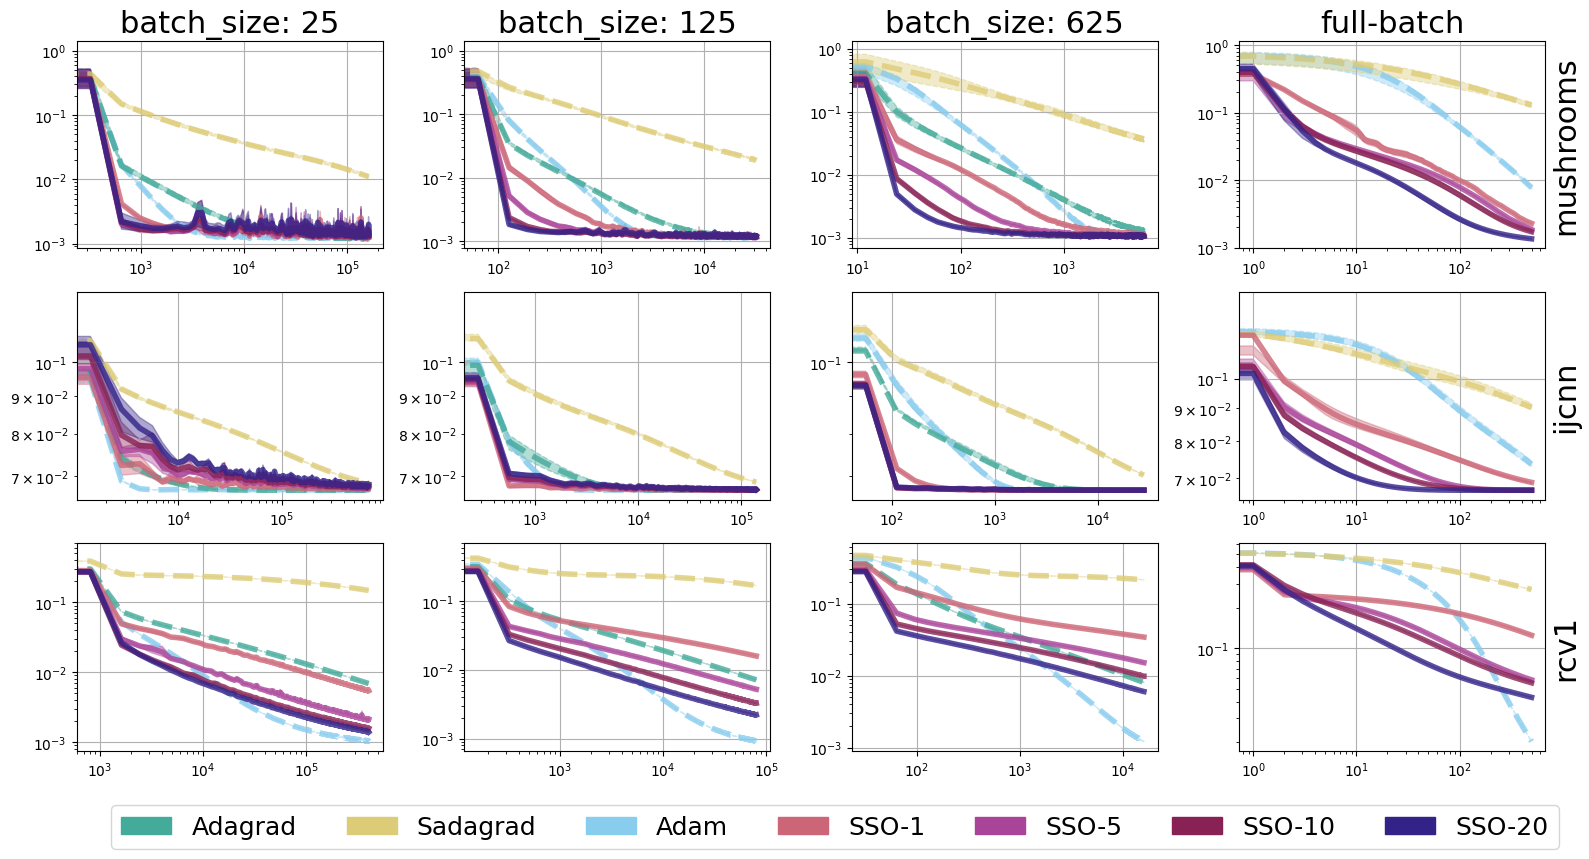

missing Adagrad   mushrooms 25
missing Adagrad   mushrooms 125


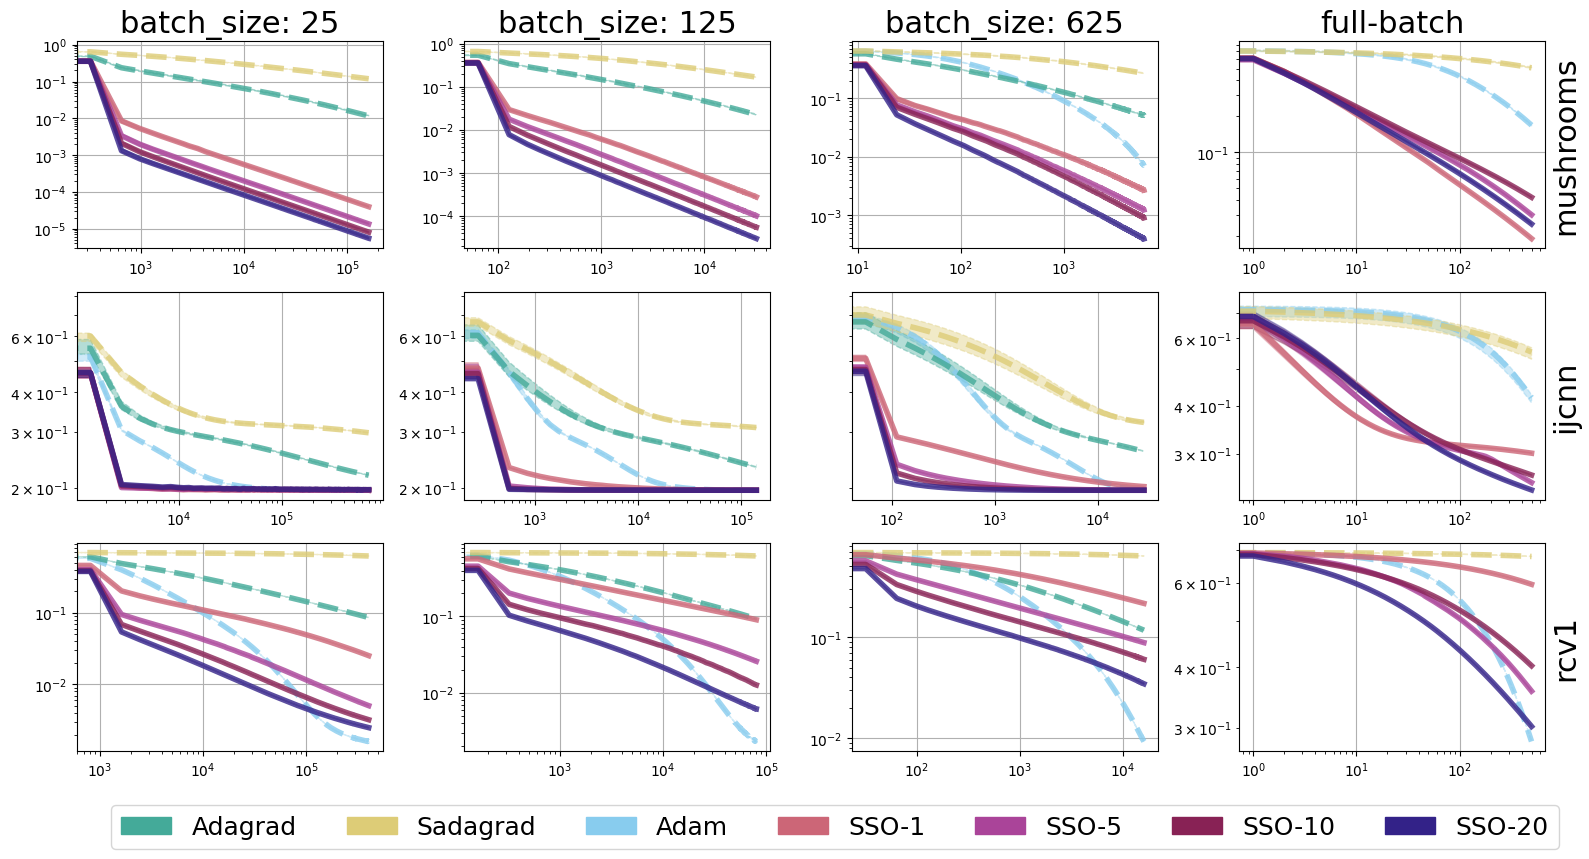

In [20]:
# loss comparison
generate_sada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
generate_sada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_sada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# generate_sada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

In [33]:
 def generate_ada_figure(loss, schedule, wandb_records, fig_name, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'Adagrad': '#44AA99' , 'Sadagrad': '#DDCC77', 'Adam': '#88CCEE'} 
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['Adagrad', 'Sadagrad', 'Adam'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

        # Adagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adagrad', 
                                         linestyle='dashed', color=colormap['Adagrad'])
        else:
            print('missing Adagrad  ', dataset_name, 'full-batch')
        
        # Adagrad
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adam', 
                                         linestyle='dashed', color=colormap['Adam'])
        else:
            print('missing Adam  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': 'Diag_Ada_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log") 
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0
            
            # Adam
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adam', 
                                             linestyle='dashed', color=colormap['Adam'])
            else:
                print('missing Adam  ', dataset_name, batch_size)
            
            # Adagrad
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  '_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adagrad',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adagrad', 
                                             linestyle='dashed', color=colormap['Adagrad'])
            else:
                print('missing Adagrad  ', dataset_name, batch_size)
            
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, '_step': 499.0,
                        'loss': loss, 'algo': 'Diag_Ada_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size) 
            
            axs[row][col].grid()     
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch-size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][-1].set_ylabel(dataset_name, fontsize=22)
            axs[row][-1].yaxis.set_label_position("right") 
        
        axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
        axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        axs[row][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100  
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-ada_sso-'+fig_name+loss+'.pdf', bbox_inches='tight')
    plt.show() 

missing FMDopt   20 ijcnn 25
missing FMDopt   5 rcv1 full-batch


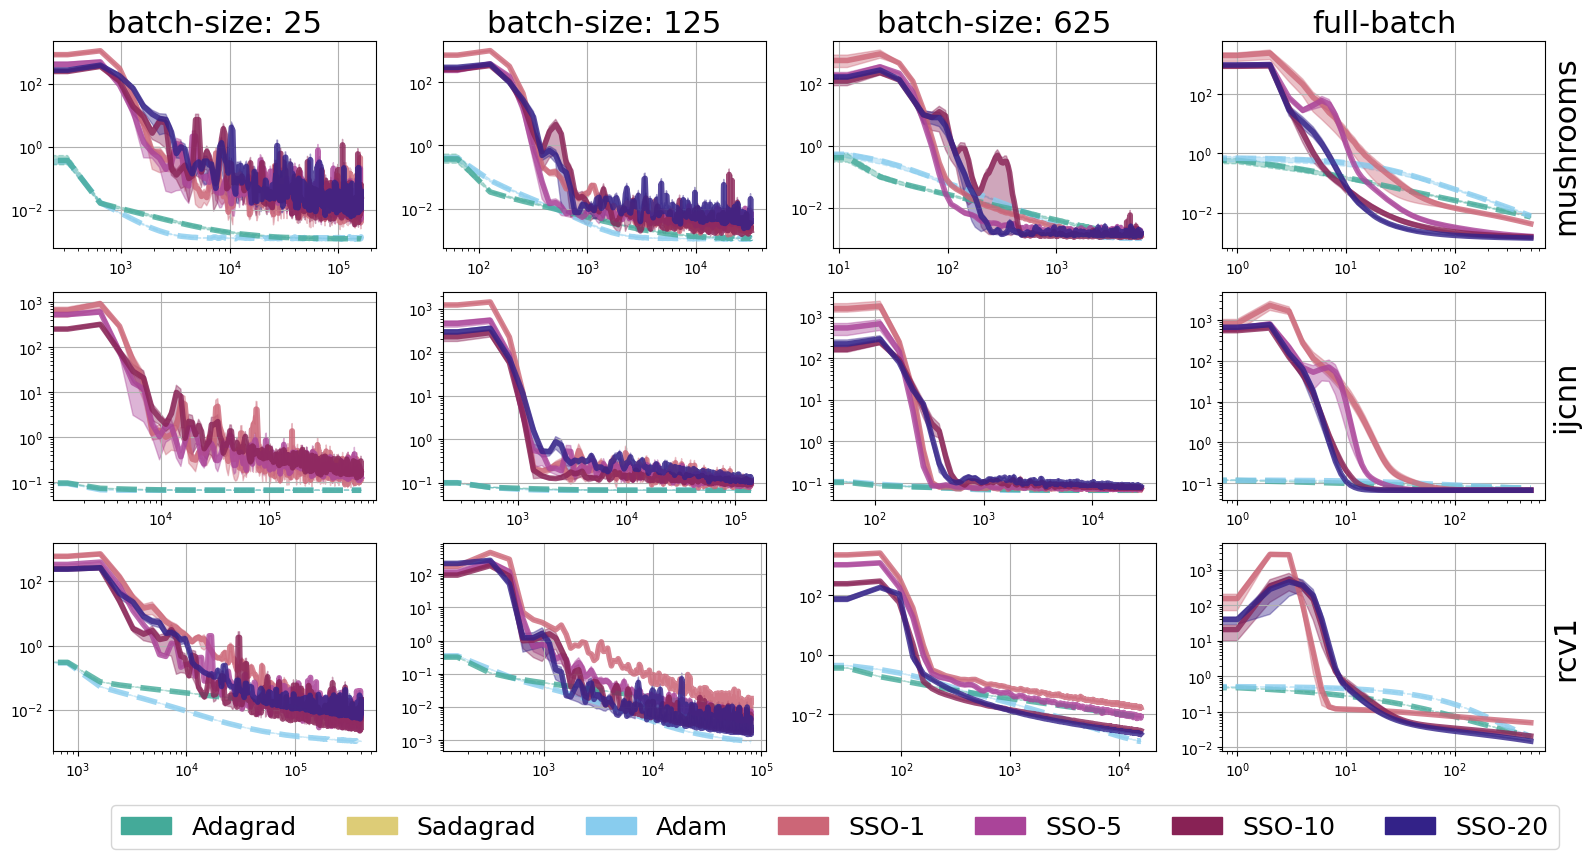

missing Adam   mushrooms 25
missing FMDopt   1 mushrooms 25
missing FMDopt   5 mushrooms 25
missing FMDopt   10 mushrooms 25
missing FMDopt   20 mushrooms 25
missing Adam   mushrooms 125
missing FMDopt   1 mushrooms 125
missing FMDopt   5 mushrooms 125
missing FMDopt   10 mushrooms 125
missing FMDopt   20 mushrooms 125
missing FMDopt   1 mushrooms 625
missing FMDopt   5 mushrooms 625
missing FMDopt   10 mushrooms 625
missing FMDopt   20 mushrooms 625
missing FMDopt   1 ijcnn 25
missing FMDopt   5 ijcnn 25
missing FMDopt   10 ijcnn 25
missing FMDopt   20 ijcnn 25
missing FMDopt   1 ijcnn 125
missing FMDopt   5 ijcnn 125
missing FMDopt   10 ijcnn 125
missing FMDopt   20 ijcnn 125
missing FMDopt   1 ijcnn 625
missing FMDopt   5 ijcnn 625
missing FMDopt   10 ijcnn 625
missing FMDopt   20 ijcnn 625
missing FMDopt   1 rcv1 25
missing FMDopt   5 rcv1 25
missing FMDopt   10 rcv1 25
missing FMDopt   20 rcv1 25
missing FMDopt   1 rcv1 125
missing FMDopt   5 rcv1 125
missing FMDopt   10 rcv1 125


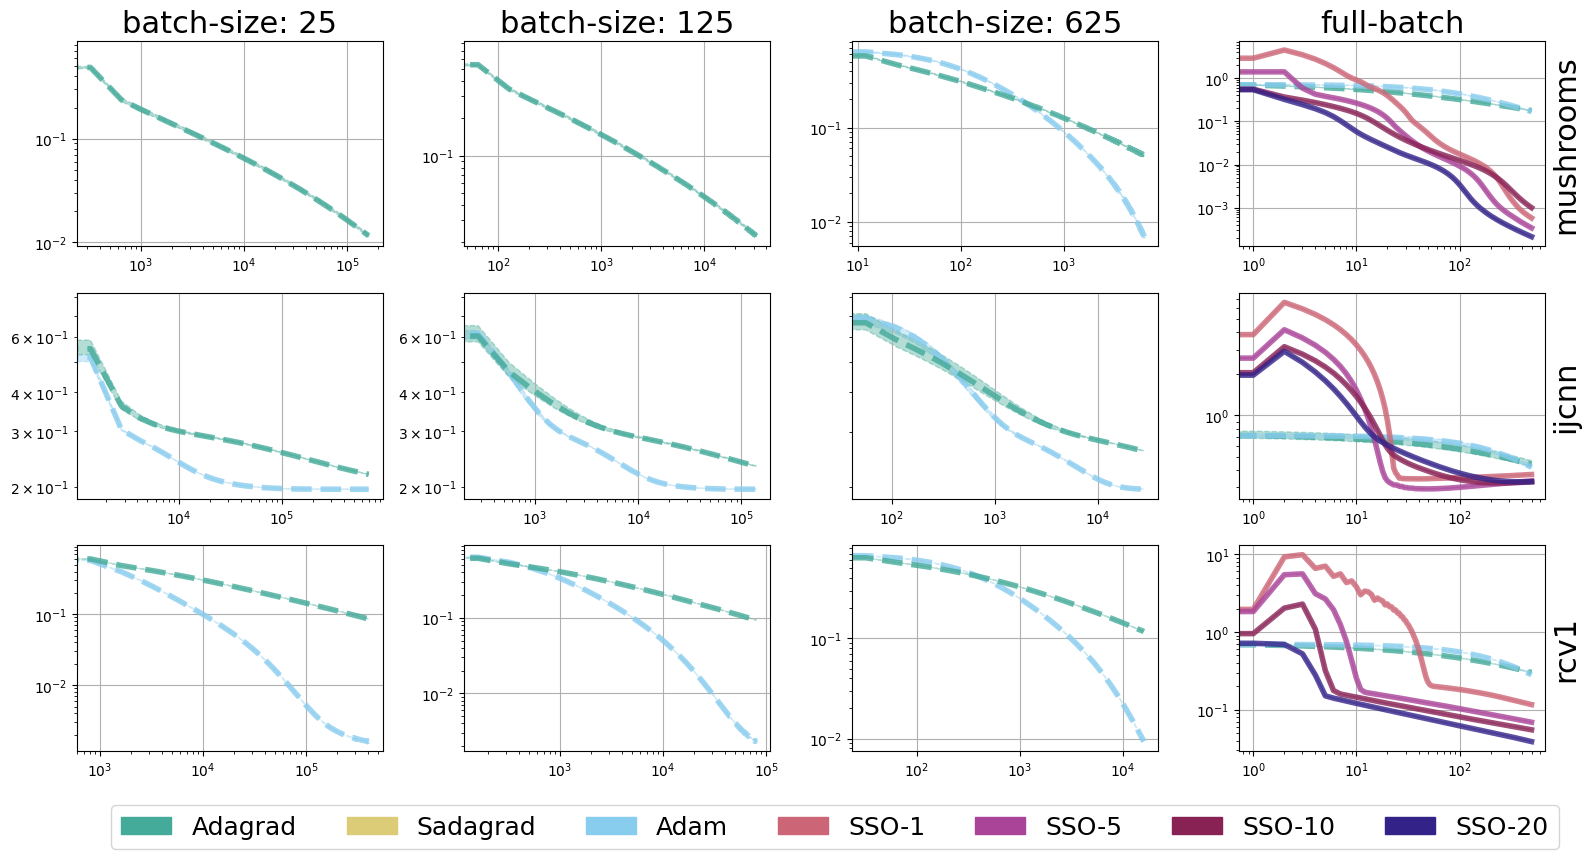

In [34]:
 # loss comparison
generate_ada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
generate_ada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='avg_loss')
# grad-norm comparison
# generate_ada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# generate_ada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_ada_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_ada_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')